# <font color='#2684ff'>rawMSA_disorder: a server to predict protein disorder</font>

<img src="https://github.com/clami66/AF_unmasked/raw/main/fig/header.png" height="200">

This server allows to run rawMSA_disorder.

This version of rawMSA_disorder relies on MMseqs2 alignments, run by the [ColabFold](https://github.com/sokrypton/ColabFold) MSA server. Some of the code on this notebook is also based or taken from the ColabFold notebook.

<font color='#2684ff'>**References**</font>

If you use this version of rawMSA_disorder in your research, consider citing:

- Mirabello et al. "rawMSA: End-to-end Deep Learning using raw Multiple Sequence Alignments" [10.1371/journal.pone.0220182](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220182)
- Mirdita et al. "ColabFold: making protein folding accessible to all" [Nature Methods volume 19, pages 679–682 (2022)](https://www.nature.com/articles/s41592-022-01488-1)

## <font color='#2684ff'>Instructions</font>

The job is configured and launched from the side menu on the left. 

1. <font color='#2684ff'> **Select a name for your job**</font>. Confirm by clicking on the button that will appear or press enter. If you wish to run an example, use the slide button on top and an example sequence from CAID will be used.
1. <font color='#2684ff'> **Upload sequence**</font>. A FASTA file containing a single protein sequence to predict.
1. <font color='#2684ff'> **Press the "Predict disorder" button**</font>
1. <font color='#2684ff'> **Check and download outputs**</font>. Results will appear in this window. To download the predictions, click on "Output files" at the bottom of the side menu.

## <font color='#2684ff'>Outputs</font>

Outputs will appear below:


In [14]:
import mercury as mr

import tqdm
import numpy as np
import sys, os
import shutil

from pathlib import Path
cwd = Path.cwd()
sys.path.insert(0, f"{cwd}/../docker/")

import argparse
from time import gmtime, strftime
import time
import csv

from tqdm import tqdm
import glob
import importlib_metadata

from Bio import SeqIO
import tensorflow as tf
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
from utils.NetUtils import CustomMetrics, DataProcessor, a3m2aln, aln2num, pad_or_trim_array
from colabfold.batch import get_msa_and_templates, msa_to_str
from colabfold.utils import DEFAULT_API_SERVER, get_commit

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


In [15]:
# config
trained_models = f"{cwd}/../docker/data/models"

app = mr.App(title="rawMSA_disorder",
        description="",
        show_code=False,
        show_prompt=False,
        continuous_update=True,
        static_notebook=False,
        show_sidebar=True,
        full_screen=True,
        allow_download=False,
        allow_share=True,
        stop_on_error=True
)

test_checkbox = mr.Checkbox(value=False, label="Slide button to run with test protein (P53_HUMAN)")
is_test = test_checkbox.value

mercury.App

mercury.Checkbox

In [16]:
jobname = mr.Text(value="" if not is_test else "test", label="Job name", rows=1)
if not jobname.value:
    mr.Stop()

mercury.Text

In [17]:
outdir = mr.OutputDir()

out_path = Path(outdir.path)
out_path.mkdir(parents=True, exist_ok=True)
targets = out_path.joinpath(f"{jobname.value}.fasta")

mercury.OutputDir

In [18]:
# add file upload widget
if is_test:
    fasta = f"{cwd}/../input_fasta/test.fasta"
else:
    f = mr.File(label="Upload a .fasta file for one target protein", max_file_size="1MB")
    fasta = f.filepath
    
    if not fasta:
        mr.Stop()

mercury.File

In [6]:
fasta = Path(fasta)

In [12]:
def is_fasta(path):
    records = list(SeqIO.parse(path, "fasta"))
    return records if records else None

_ = shutil.copyfile(fasta, targets)

records = is_fasta(targets)
if not records:
  raise ValueError("""The input does not appear to be in fasta format
  Example of fasta format input:
  > H1142_A
  GLEKDFLPLYFGWFLTK...
  > H1142_B
  EVQLEESGGGLVQAGGS...
  """)
elif len(records) > 1:
  raise ValueError(f"Detected {len(records)} sequences in .fasta file. Please upload a single sequence at a time")

with open(targets, "r") as f:
  print(color.BOLD + color.RED + "Fasta sequences:" + color.END)
  print(f.read())

record = records[0]

Fasta sequences:
>12E8_2
EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLEWIGWIDPEIGDTEYVPKFQGKATMTADTSSNTAYLQLSSLTSEDTAVYYCNAGHDYDRGRFPYWGQGTLVTVSAAKTTPPSVYPLAPGSAAQTNSMVTLGCLVKGYFPEPVTVTWNSGSLSSGVHTFPAVLQSDLYTLSSSVTVPSSTWPSETVTCNVAHPASSTKVDKKIVPRD



In [8]:
msa_lines = None
use_templates = False
custom_template_path = None
pair_mode = "unpaired"
pairing_strategy = "greedy"
host_url = DEFAULT_API_SERVER
version = importlib_metadata.version("colabfold")
commit = get_commit()
if commit:
  version += f" ({commit})"
user_agent = f"colabfold/{version}"

msa_file_path = f"{out_path}/{jobname.value}.a3m"
if not os.path.exists(msa_file_path):
    print("Running ColabFold MSA server query...")
    unpaired_msa, paired_msa, query_seqs_unique, query_seqs_cardinality, template_features = get_msa_and_templates(jobname.value, 
                                                                                                                   [str(r.seq) for r in records], 
                                                                                                                   msa_lines, 
                                                                                                                   out_path, 
                                                                                                                   "mmseqs2_uniref", 
                                                                                                                   use_templates,
                                                                                                                   custom_template_path, 
                                                                                                                   pair_mode, 
                                                                                                                   pairing_strategy, 
                                                                                                                   host_url, 
                                                                                                                   user_agent)

    with open(msa_file_path, "w") as msa_out:
        msa_out.write(unpaired_msa[0])

a3m2aln(msa_file_path, f"{out_path}/{jobname.value}.aln")  #a3m to aln
aln2num(f"{out_path}/{jobname.value}.aln", f"{out_path}/{jobname.value}.num")   # aln2num

# NUM to feature .npy
msa_array = np.loadtxt(f"{out_path}/{jobname.value}.num", dtype=int)
if len(np.shape(msa_array)) == 1:
    msa_array = msa_array[np.newaxis, :]
else:
    msa_array_ = pad_or_trim_array(msa_array, 3000).T
    data = {'features': msa_array_}   # Fill feature set
    np.save(f"{out_path}/{jobname.value}.npy", data)

In [9]:
models = []
for model_path in glob.glob(f"{trained_models}/*"):
    alignment_max_depth = int(model_path.split('_')[-4]) # Required model_name to be in a specific_format
    model = tf.keras.models.load_model(model_path, custom_objects={"balanced_acc": CustomMetrics.balanced_acc})
    models.append((model, alignment_max_depth))

/proj2/rawmsa_disorder/notebooks/../docker/data/models/best_model_mmseqs_full_1000_ConvLSTM_ep88_0.57.h5
/proj2/rawmsa_disorder/notebooks/../docker/data/models/20240414-141351_best_model_mmseqs_full_1000_ConvLSTM_ep14_0.7.h5


In [ ]:
run = mr.Button(label="Predict disorder")

Predicting disorder
test took 0.37456178665161133 secs


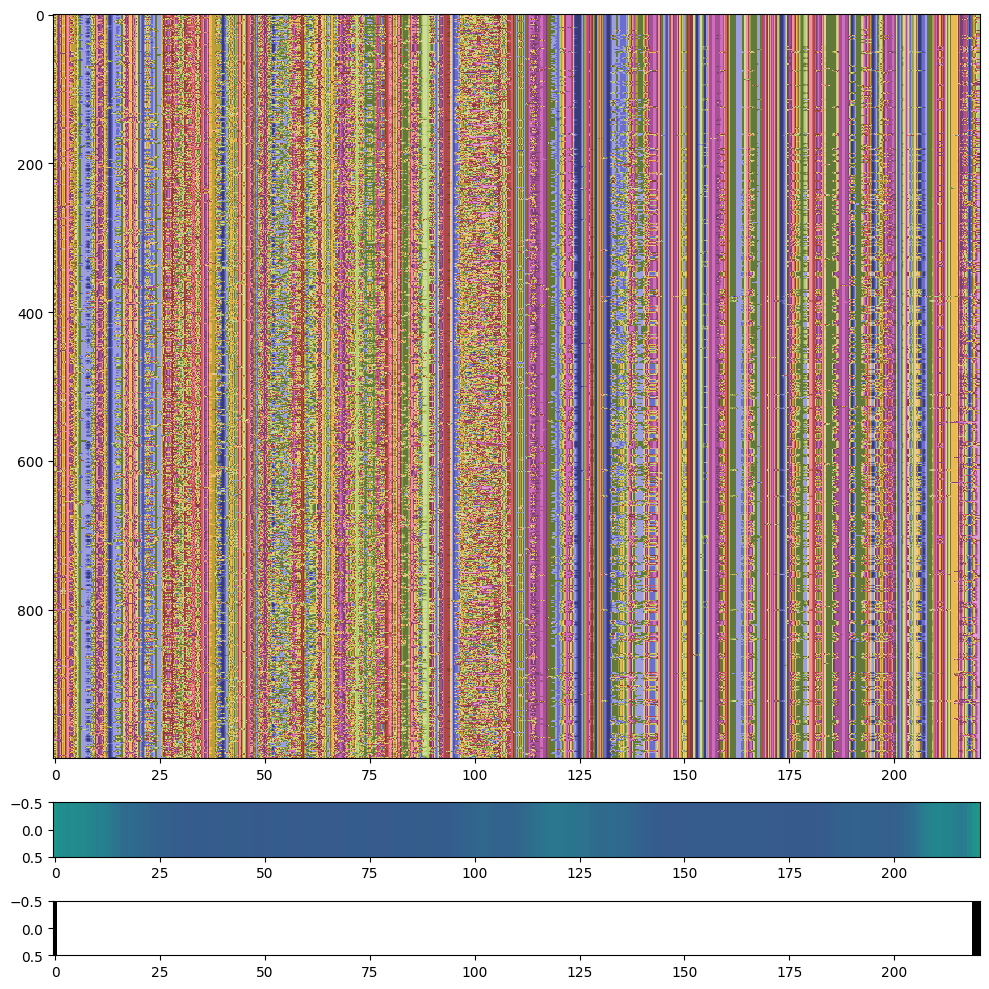

In [13]:
if run.clicked:
    exec_times = []
    print(f"Predicting disorder")
    
    start_time = time.time()
    list_y = []
    for ew_model, alignment_max_depth in models:
        features = np.load(f"{out_path}/{jobname.value}.npy", allow_pickle=True).item()['features']
        X = features[:, :alignment_max_depth][np.newaxis, :] #.reshape(length * alignment_max_depth)[np.newaxis, :]
    
        y = ew_model.predict(X,verbose=0)
        list_y.append(np.squeeze(y))
        
    mean_y = np.mean(list_y, axis=0)                    # Compute mean logits
    mean_y = tf.nn.softmax(mean_y, axis=1, name=None)   # Apply softmaax on mean logits
    logits_positive = mean_y[:,1]                       # Get positive probs
    y_binary = np.argmax(mean_y, axis=-1)               # Binarize
    
    # Write results to file
    with open(f'{out_path}/{jobname.value}.caid', 'w') as reader: 
        reader.write(f'>{jobname.value}\n')
        for (i, residue, logit, pred) in zip(range(len(record.seq)), list(record.seq), logits_positive, y_binary):
            reader.write('{}\t{}\t{:.3f}\t{}\n'.format(i + 1, residue, logit, pred)) 
    end_time = time.time()
    exec_times.append(end_time - start_time)
    print(f'{jobname.value} took {end_time - start_time} secs')
    
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(10) 
    
    # Define subplots with unequal sizes
    ax1 = fig.add_subplot(gs[:8]) 
    ax2 = fig.add_subplot(gs[8]) 
    ax3 = fig.add_subplot(gs[9]) 
    
    res_1 = np.array(logits_positive).reshape(-1,1)
    res_2 = np.array(y_binary).reshape(-1,1)
    
    ax1.imshow(X[0].T, aspect='auto', cmap='tab20b')
    ax2.imshow(res_1.T, aspect='auto' , vmin=0, vmax=1)
    ax3.imshow(res_2.T, aspect='auto', cmap='binary')
    plt.tight_layout()
    plt.show()


## <font color='#2684ff'>Download results </font>

Click on the button at the bottom of the menu:

